# Portfolio Cumulative Return Forecasts
Bryant Crocker 

Importings necessary libraries for analysis.

In [104]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import ffn
from scipy.optimize import minimize
init_notebook_mode(connected=True)
plt.style.use('ggplot')
%matplotlib inline

Using the ffn library, I pull in daily stock data.  If the code returns an error, run again and again until it works.  This has to do with issues with the notoriously problematic Yahoo Finance API.

In [105]:
# download price data from Yahoo! Finance. By default,
# the Adj. Close will be used.
prices = ffn.get('nke,ads,vfc,uaa,aeo,lb,goos,ges,rl', start='2017-01-01')

#Use the pd.head() method to get an idea of what the data looks like and see what day the data starts at
prices.head()

,nke,ads,vfc,uaa,aeo,lb,goos,ges,rl
Date,,,,,,,,,
2017-03-16,56.688087,241.652786,52.063850,19.820000,13.816463,45.943016,16.080000,9.932523,78.408157
2017-03-17,56.884922,241.573914,51.871555,19.379999,13.616364,47.055508,17.230000,10.344471,78.079201
2017-03-20,57.750988,241.110474,51.794640,19.590000,13.340034,46.393532,17.100000,10.188846,76.879478
2017-03-21,57.091595,235.934113,51.006222,18.990000,12.997005,45.216679,16.520000,9.959985,75.689430
2017-03-22,53.066349,237.491974,51.044682,19.090000,13.216164,44.003059,16.049999,9.758589,75.670074


### Selected Securities:

* nke - Nike Athletics

* ads - Adidas Athletics

* vfc - Vans Footwear Company

* uaa - Under Armor Athletics

* aeo - American Eagle Outfitters

* lb - Lbrands

* goos - Canadian Goose

* ges - Guess?, Inc.

* rl - Ralph Lauren

### Returns histograms:

Often stock returns are more important than the prices themselevs.  Especially when it comes to financial modeling. 

It's noteable that their is a good range of volatility among the stocks.  In order to have a balanced portfolio we need to balance high and low risk securities.

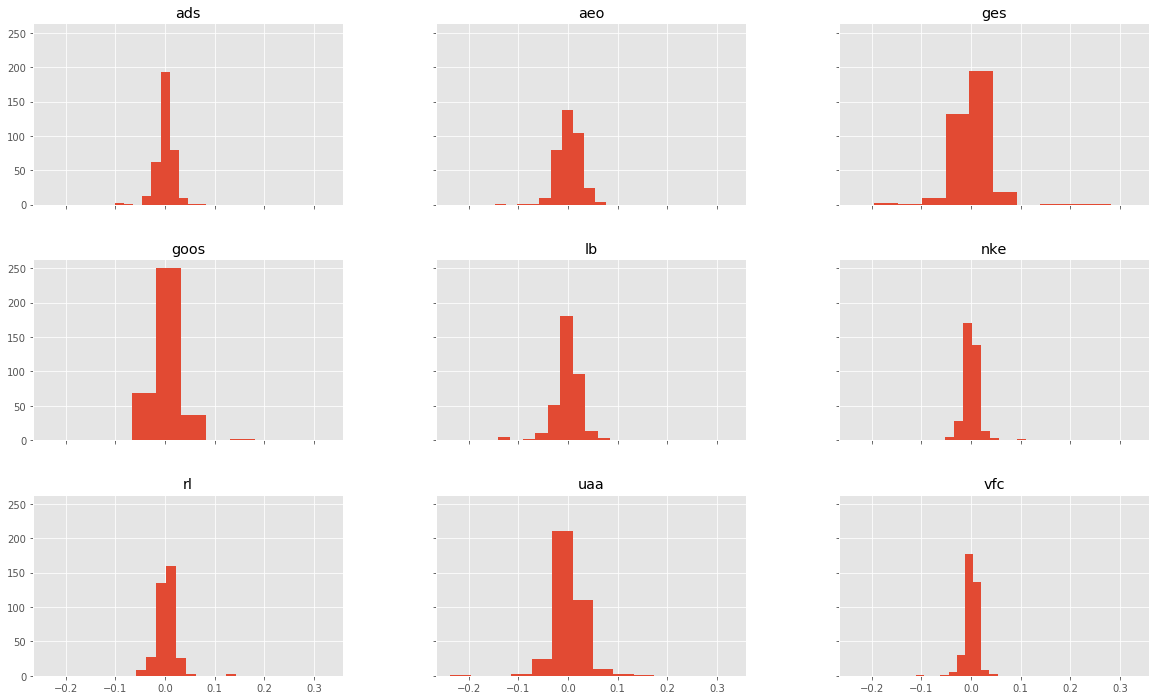

In [118]:
logreturns = prices.to_log_returns()
returns = prices.to_returns()
prices.pct_change().hist(figsize = (20, 12), sharex = True, sharey = True)
plt.savefig("INDret.png")
plt.show()

### Correlations:

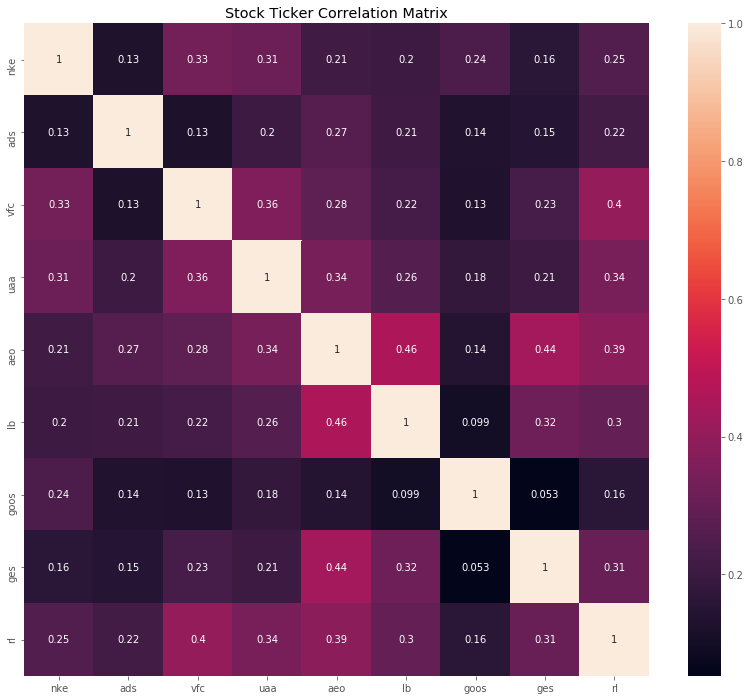

In [119]:
cormat = returns.corr()
plt.figure(figsize = (14, 12))
sns.heatmap(cormat, annot = True)
plt.title("Stock Ticker Correlation Matrix")
plt.savefig("cormat.png")

In [120]:
np.std(returns).sort_values()

vfc     0.013261
nke     0.015567
ads     0.016567
rl      0.018797
aeo     0.023754
lb      0.025759
uaa     0.029606
goos    0.032233
ges     0.034653
dtype: float64

### Security Prices Over Time

It's clear that Adidas's price is much higher than that of other securities.  There certainley is some overplotting here but I'm not overly concerned with this plot being good. I am not particularly interested in stock prices in this analysis.
I am more interested in the returns of the securities. 

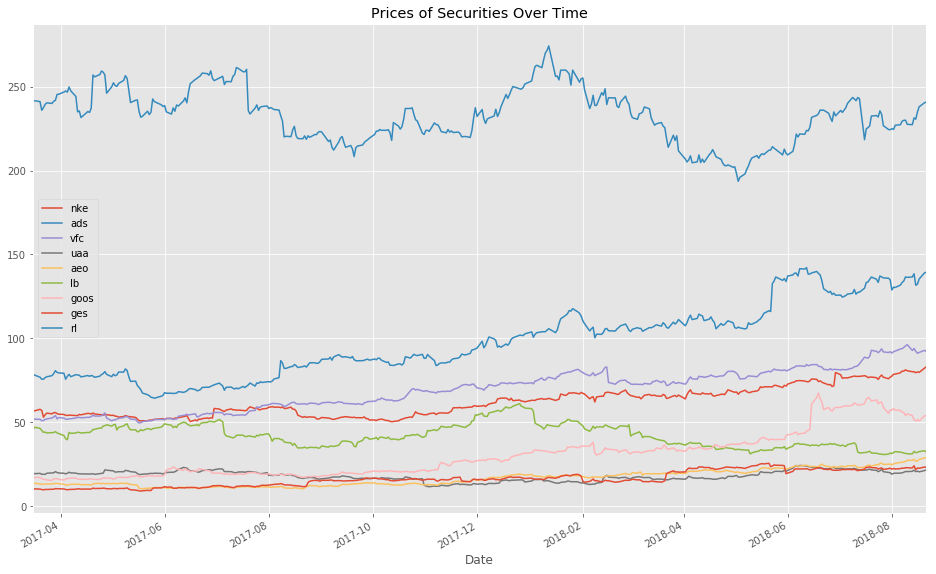

In [121]:
prices.plot(figsize = (16,10))
plt.title("Prices of Securities Over Time")
plt.show()

### Mean Variance Optimization Portfolio:

This portfolio uses the weights that maximizes the sharpe ratio on the efficent frontier.

In [122]:
weights = ffn.calc_mean_var_weights(logreturns, covar_method = "standard")

In [123]:
def cum_ret_plot(returns, weights):
    '''
    A function that plots the cumulative returns of a dataframe of returns based on a series of weights. The function 
    produces an output plot and retuns a weighted portfolio series
    '''
    # Calculate the weighted stock returns
    WeightedReturns = returns.mul(weights, axis=1)

    # Calculate the portfolio returns
    returns['Portfolio'] = WeightedReturns.sum(axis=1)

    # Plot the cumulative portfolio returns over time
    plt.figure(figsize = (14,10))
    CumulativeReturns = ((1+returns["Portfolio"]).cumprod()-1)
    plt.subplot(211)
    CumulativeReturns.plot()
    plt.ylabel("Cumulative Returns")
    plt.title("Cumulative Returns Over Time")
    plt.subplot(212) 
    weights.sort_values().plot(kind = "bar")
    plt.title("Portfolio Weights")
    plt.ylabel("Proportion")
    plt.xlabel("Security")
    plt.tight_layout()
    return(CumulativeReturns)

ads      0.00%
aeo     10.56%
ges      5.91%
goos    23.13%
lb       0.00%
nke      1.65%
rl       7.00%
uaa      0.00%
vfc     51.76%
dtype: object

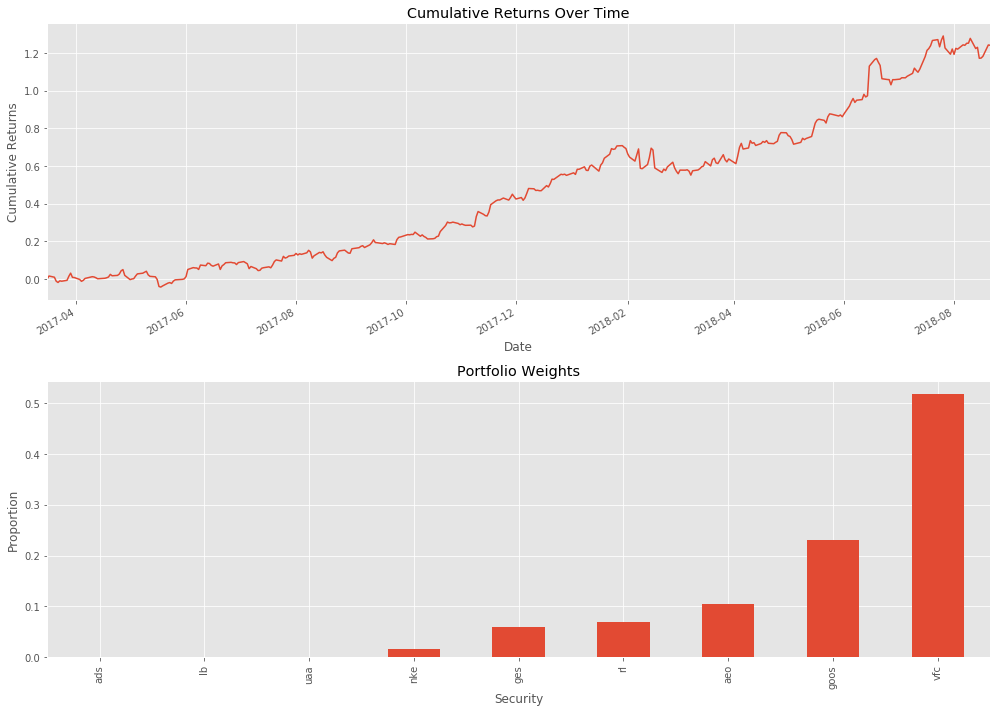

In [124]:
returns_port = cum_ret_plot(returns, weights)
plt.savefig("MeanVar.png")
weights.as_format('.2%')

In [125]:
# forecasted portfolio returns
from fbprophet import Prophet
def fit_prophet(df):
    df = pd.DataFrame(df).reset_index().rename(columns={"Date": "ds", "Portfolio": "y"})
    m = Prophet()
    m.fit(df)
    # Python
    future = m.make_future_dataframe(periods=365)
    future.tail()
    # Python
    forecast = m.predict(future)
    return(m, forecast, returnsport_df)
    

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


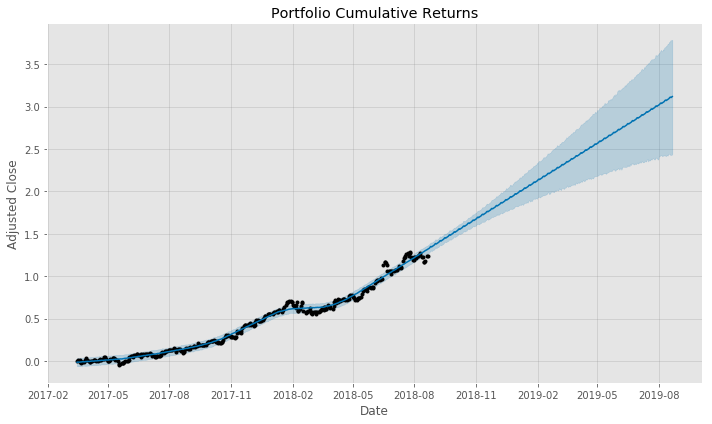

In [126]:
m, forecast, returnsport_df = fit_prophet(returns_port)
m.plot(forecast)
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.title("Portfolio Cumulative Returns")
plt.tight_layout()
plt.savefig("MeanVarForecast.png")
plt.show()

### Inverse Volatility Optimization Portfolio 

Calculates weights proportional to inverse volatility of each column.

In [127]:
returns.drop('Portfolio', axis = 1, inplace = True)
weights2 = ffn.calc_inv_vol_weights(returns)
weights2.as_format('.2%')
weights2

nke     0.150164
ads     0.141101
vfc     0.176279
uaa     0.078957
aeo     0.098409
lb      0.090750
goos    0.072523
ges     0.067459
rl      0.124359
dtype: float64

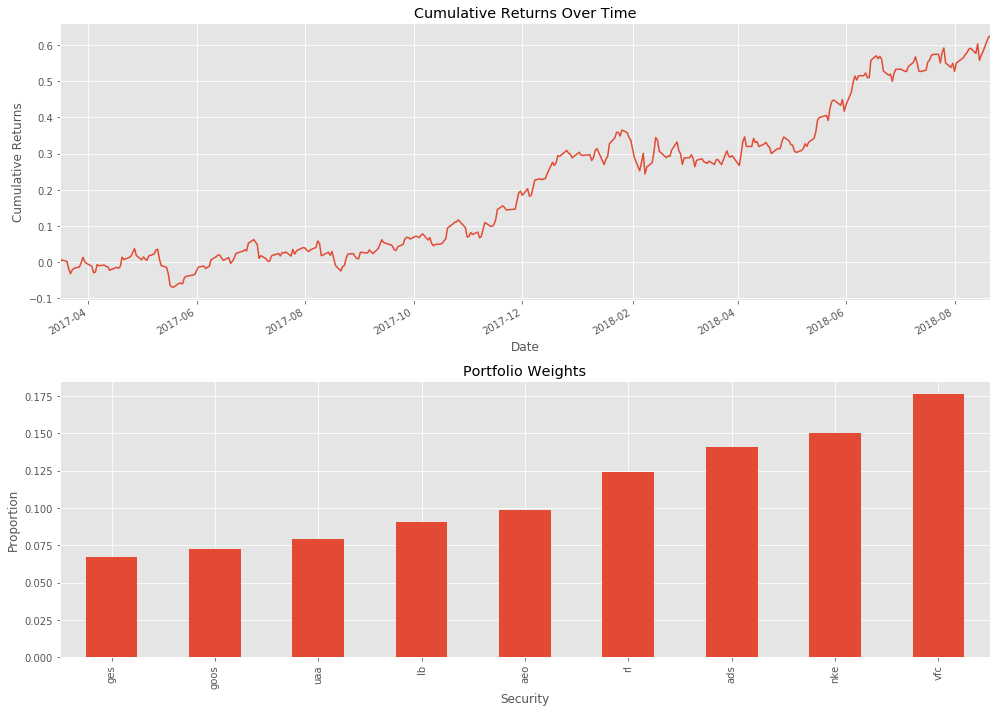

In [128]:
returns_port2 = cum_ret_plot(returns, weights2)
plt.savefig("InvVol.png")
plt.show()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


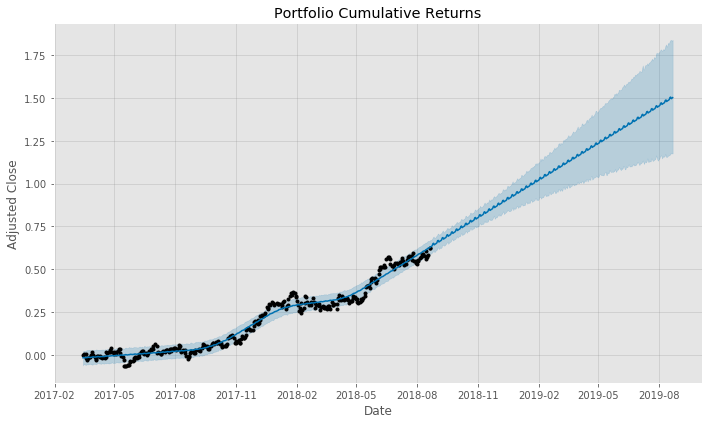

In [129]:
returnsport_df2 = pd.DataFrame(returns_port2).reset_index().rename(columns={"Date": "ds", "Portfolio": "y"})
m = Prophet()
m.fit(returnsport_df2)
# Python
future = m.make_future_dataframe(periods=365)
future.tail()
# Python
forecast = m.predict(future)
# forecasted portfolio returns
m.plot(forecast)
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.title("Portfolio Cumulative Returns")
plt.tight_layout()
plt.savefig("Portfolio2.png")
plt.show()

### Equal Weight Portfolio

In [99]:
weights3 = 1 / len(prices.columns)
weights3 = [weights3] * len(prices.columns)
names = prices.columns
weights3 = pd.Series(weights3, index = names)
weights3

nke     0.111111
ads     0.111111
vfc     0.111111
uaa     0.111111
aeo     0.111111
lb      0.111111
goos    0.111111
ges     0.111111
rl      0.111111
dtype: float64

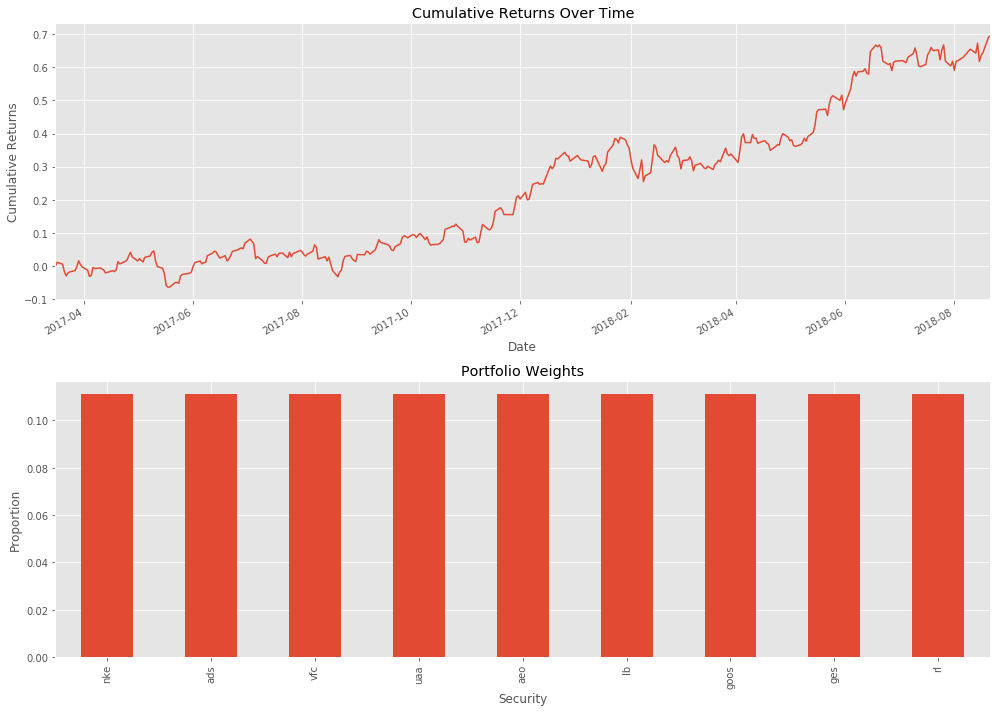

In [100]:
returns_port2 = cum_ret_plot(returns, weights3)
plt.savefig("Equal.png")
plt.show()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


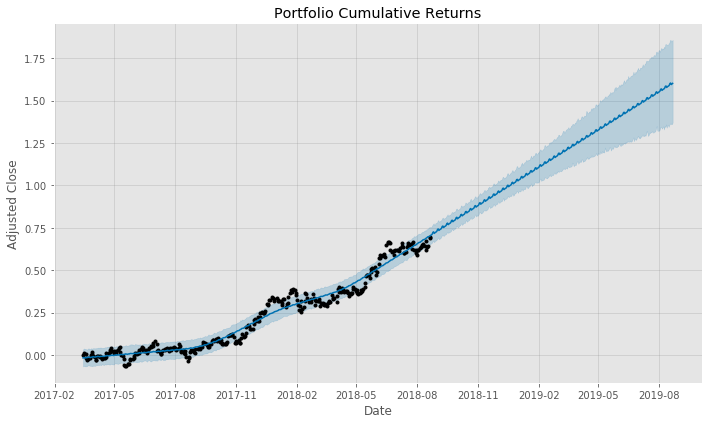

In [101]:
m, forecast, returnsport_df = fit_prophet(returns_port2)
m.plot(forecast)
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.title("Portfolio Cumulative Returns")
plt.tight_layout()
plt.savefig("Portfolio.png")
plt.show()